<center><h1>Analysis of NYC High School Data | SAT Scores</h1></center>

<div>
<img src="sat.jpeg" />
</div>


# Table of Contents
1. [**Introduction**](#1)
* [Data Description](#1.1)
2. [**Data Exploration**](#2)
* [Explore the SAT Data](#2.1)
* [Explore the Remaining Data](#2.2)
3. [**Data Cleaning**](#3)
* [Condense Datasets](#3.1)
4. [**Data Analysis**](#4)
* [Exploring Enrollment](#4.1)
* [Exploring Safety](#4.2)
* [Racial Differences](#4.3)
* [Gender Differences](#4.4)
* [AP scores](#4.5)
5. [**Conclusions**](#5)

<a id="1"></a>
# Introduction

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's important to perform well. 
The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the dataset for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

**Project Goal:**
One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. In this project, we are going to investigate the correlations between SAT scores and factors such as race, gender, income, and more.

<a id="1.1"></a>
## Data Description

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2)

Unfortunately, combining both of the datasets won't give us all of the demographic information we want to use. We'll need to supplement our data with other sources to do our full analysis.

The same website has several related datasets covering demographic information and test scores. Here are the links to all of the datasets we'll be using:
* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school.

All of these datasets are interrelated. Let's read in the data and explore the different datasets before we can combine them.

<a id="2"></a>
# Data Exploration
## Read in the Data

In [1]:
import pandas as pd
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}
for file in data_files:
    df = pd.read_csv('data/'+file)
    data[file.split('.')[0]] = df

<a id="2.1"></a>
## Explore the SAT Data
What we're mainly interested in is the SAT dataset, which corresponds to the dictionary key `sat_results`. This dataset contains the SAT scores for each high school in New York City. We eventually want to correlate selected information from this dataset with information in other datasets.      
Let's explore `sat_results` to see what we can discover.

In [2]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


**Insights**
* The `DBN` appears to be a unique ID for each school.
* We can tell from the first few rows of names that we only have data about high schools.
* There's only a single row for each high school, so each `DBN` is unique in the SAT data.
* We may eventually want to combine the three columns that contain SAT scores -- `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score` and `SAT Writing Avg. Score` -- into a single column to make the scores easier to analyze.       


<a id="2.2"></a>
## Explore the Remaining Data
Let's explore the other datasets to see if we can gain any insights into how to combine them. 

In [3]:
for key in data:
    print(data[key].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

**Insights**
* Each dataset appears to either have a `DBN` column or information we need to create one. We can therefore use a `DBN` column to combine the datasets.
* Some fields look interesting for mapping -- particularly `Location 1` which contains coordinates inside a larger string.
* Some of the datasets appear to contain multiple rows for each school. We'll have to do some preprocessing to ensure that each `DBN` is unique within each dataset. 

## Read in the Survey Data
The `survey_all.txt` and `survey_d75.txt` files are tab delimited and encoded with `Windows-1252` encoding. We'll need to specify the encoding and delimiter as we read the datasets, to ensure it reads the surveys in properly. 

In [4]:
all_survey = pd.read_csv('data/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('data/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Insights**
* There are over `2000` columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones.
* The survey data has a `dbn` column that we'll convert to uppercase, to make it consistent with the other data sets.

<a id="3"></a>
# Data Cleaning
## Clean up Surveys
We'll need to filter the columns to remove the ones we don't need. There's a data dictionary at the [original data download location](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8), which tells us what each column represents. We will use the data dictionary to determine which columns to use. 

In [5]:
survey['DBN'] = survey['dbn']
survey_fields = [
      "DBN",
    "rr_s",
    "rr_t",
    "rr_p",
    "N_s",
    "N_t",
    "N_p",
    "saf_p_11",
    "com_p_11",
    "eng_p_11",
    "aca_p_11",
    "saf_t_11",
    "com_t_11",
    "eng_t_11",
    "aca_t_11",
    "saf_s_11",
    "com_s_11",
    "eng_s_11",
    "aca_s_11",
    "saf_tot_11",
    "com_tot_11",
    "eng_tot_11",
    "aca_tot_11",
]
survey = survey.loc[:, survey_fields]
data['survey'] = survey
data['survey'].head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


## Insert DBN Fields
Some of the datasets like `class_size` and `hs_directory` don't have a `DBN` column. `hs_directory` does have a `dbn` column, though, so we can just rename it.

However, `class_size` doesn't appear to have the column at all. Here are the first few rows of the data set:


In [6]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


Here are the first few rows of the `sat_results` data, which does have a `DBN` column:

In [7]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


**Insights**
The `DBN` in the `sat_results` data is just a combination of the `CSD` and `SCHOOL CODE` columns in the `class_size` data. The main difference is that the `DBN` is padded, so that the `CSD` portion of it always consists of 2 digits.      
Let's insert this field in `class_size` data:

In [8]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    return str(num).zfill(2)
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


## Combine the SAT Scores
Totaling up the SAT scores for the different sections of the exams, makes it easier to correlate scores with demographic factors because we'll be working with a single number. 

In [9]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for col in cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors='coerce')
    
data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']
data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

## Parse Geographic Coordinates for Schools
To enable us to map the schools and uncover any geographic patterns in the data, we'll parse the latitude and longitude coordinates for each school.
The coordinates are currently in the text field `Location 1` in the `hs_directory` dataset.       
Let's extract the coordinates from this field:

In [10]:
import re

# Latitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810,-73.806500


<a id="3.1"></a>
## Condense Datasets
While the main dataset we want to analyze, `sat_results`, has unique `DBN` values for every his school in New York City, other datasets aren't as clean. For instance, a single row in the `sat_results` dataset may match multiple rows in `class_size` dataset. 

This situation creates problems, because we don't know which of the multiple entries in the `class_size` dataset we should combine with the single matching entry in `sat_results`.

To resolve this issue, we'll condense the `class_size`, `graduation` and `demographics` datasets so that each `DBN` is unique. 
### Class size Dataset

In [11]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


The first few rows all pertain to the same school, which is why the `DBN` appears more than once. It looks like each school has multiple values for `GRADE`, `PROGRAM TYPE` `CORE SUBJECT (MS CORE and  9-12 ONLY)` and `CORE COURSE (MS CORE and 9-12 ONLY)`.  

Looking at the unique values for `GRADE` we get the following:


In [12]:
data['class_size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Since we're dealing with high schools, we're only concerned with grades `9` through `12`. We only want to pick rows where the value in the `GRADE` column is `09-12`.

Looking at the unique values for `PROGRAM TYPE`, we get the following:

In [13]:
data['class_size']['PROGRAM TYPE'].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

Each school can have multiple program types. Since `GEN ED` is the largest category by far, let's only select rows where `PROGRAM TYPE` is `GEN ED`.

In [14]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


`DBN` still isn't completely unique. This is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` and `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns. 
The two columns seem to pertain to different kinds of classes. 

Let's look at the unique values for `CORE SUBJECT (MS CORE and 9-12 ONLY)`:

In [15]:
class_size['CORE SUBJECT (MS CORE and 9-12 ONLY)'].unique()

array(['ENGLISH', 'MATH', 'SCIENCE', 'SOCIAL STUDIES'], dtype=object)

This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This gives us unique `DBN` values, while also incorporating as much data as possible into the average.

In [16]:
import numpy as np
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
data["class_size"].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Demographics Dataset

In [17]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given `DBN` from being unique is `schoolyear`. We only want to select rows where `schoolyear` is `20112012`. This will give us the most recent year of data, and also match our SAT results data.

In [18]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data['demographics'].reset_index(inplace=True)
data['demographics'].head()

,index,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
1,13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
2,20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
3,27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
4,35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Graduation Dataset

In [19]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,s,s,s,s,...,s,s,s,s,s,s,s,s,s,s
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3%,17,30.9%,45.9%,...,17,30.9%,45.9%,20,36.4%,54.1%,15,27.3%,3,5.5%
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2%,27,42.2%,62.8%,...,27,42.2%,62.8%,16,25%,37.200000000000003%,9,14.1%,9,14.1%
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%


The `Demographic` and `Cohort` columns are what prevent `DBN` from being unique in the `graduation` data. A `Cohort` appears to refer to the year the data represents, and the `Demographic` appears to refer to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is `Total Cohort`.

In [20]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


## Convert AP Test Scores to Numeric
High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. We'll need to convert the following columns: `AP Test Takers`, `Total Exams Taken` and `Number of Exams with scores 3 4 or 5`.

In [21]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    print(data['ap_2010'][col].dtypes)

float64
float64
float64


## Combine the Data
We'll be using the `DBN` column to identify matching rows across datasets. Since this project is concerned with determining demographic factors that correlate with the SAT score, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values. We'll therefore be using different merge strategies with different datasets. 

* Both the `ap_2010` and the `graduation` datasets have many missing `DBN` values, so we'll use a `left` join when we merge the `sat_results` with them. Our final dataframe will have all of the same `DBN` values as the original `sat_results` dataframe.
* `class_size`, `demographics`, `survey` and `hs_directory`, contain information that's more valuable to our analysis, and also have fewer missing `DBN` values, so we'll use the `inner` join to merge the datasets.

In [22]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

## Missing Values
To handle the missing values, we will drop the columns with more than `250` missing values, and the rest, impute with the means of the columns.

In [23]:
combined.shape

(363, 160)

Let's look at the columns with more than 250 missing values and drop the columns

In [24]:
combined.isnull().sum()[combined.isnull().sum().values > 250]

SCHOOLWIDE PUPIL-TEACHER RATIO    363
fl_percent                        363
expgrade_span_min                 362
expgrade_span_max                 362
school_type                       294
online_ap_courses                 310
online_language_courses           308
partner_financial                 292
priority05                        334
priority06                        351
priority07                        361
priority08                        363
priority09                        363
priority10                        363
dtype: int64

In [25]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [26]:
combined.isnull().sum()

DBN                                0
SCHOOL NAME                        0
Num of SAT Test Takers             0
SAT Critical Reading Avg. Score    0
SAT Math Avg. Score                0
                                  ..
priority09                         0
priority10                         0
Location 1                         0
lat                                0
lon                                0
Length: 160, dtype: int64

## Add a School District Column for Mapping
Mapping the statistics out on a school district level might be an interesting way to analyze the data. We'll add a column to the dataset that specifies the school district. The school district is just the first two characters of the `DBN`.

In [27]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

<a id="4"></a>
# Data Analysis

## Correlations
Correlations tell us how closely related two columns are. We'll be using the Pearson's correlation coefficient, to measure how closely two sequences of numbers are correlated. 

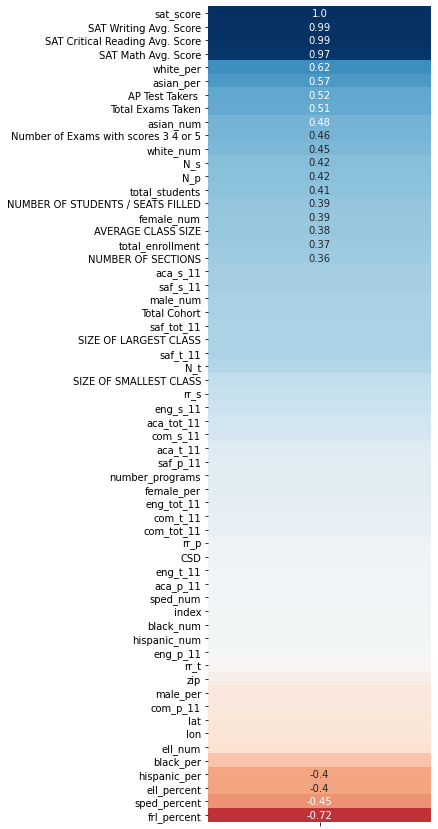

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def correlation_heatmap(dataframe):
    correlations = dataframe.corr().loc[:,['sat_score']].sort_values(by='sat_score', ascending=False)
    #dropping the null-values
    correlations = correlations[~correlations['sat_score'].isnull()]
    plt.figure(figsize=(4,15))
    ax=sns.heatmap(correlations, vmin = -1, vmax = 1, cmap = 'RdBu', annot = True, cbar=False)
    #round the values and hide labels for values between -0.25 and 0.25
    for text in ax.texts:
        t=float(text.get_text())
        if -0.35 < t < 0.35:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
    ax.tick_params(labelbottom=False)

correlation_heatmap(combined)

**Insights**
* Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, `SAT Writing Avg. Score`, and `sat_score` are strongly correlated with `sat_score`.
* `total_enrollment` has a strong positive correlation with `sat_score`. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However it looks like the opposite is true -- larger schools tend to do better on the SAT.
    * Other columns that are proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
* Both the percentage of females(`female_per`) and number of females(`female_num`) at a school correlate positively with SAT score, whereas the percentage of males(`male_per`) and the number of males(`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.
* Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
* Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parants (`aca_p_11` and `aca_t_11`).
* There is a significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).
* The percentage of students eligible for free or reduced school lunch based on household income (`frl_percent`) has a strong negative correlation with SAT scores. 

<a id="4.1"></a>
## Exploring Enrollment
Since enrollment seems to have a strong correlation, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot represents a high school, so we'll be able to see if there are any interesting patterns.

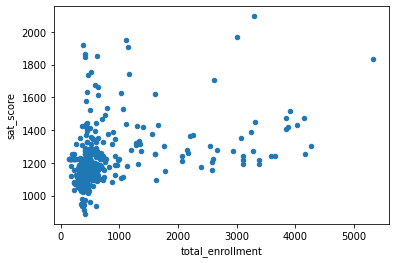

In [29]:
combined.plot.scatter(x='total_enrollment', y='sat_score')
plt.show()

From this plot, it doesn't appear there's a strong correlation between `sat_score` and `total_enrollment`. There's a large cluster of schools and then a few others going off in three different directions. 

However, there's an interesting cluster of points at the bottom left where `total_enrollment` and `sat_score` are both low. This cluster may be what is making the r value so high. Let's extract the names of the schools in this cluster and research them further. 

In [30]:
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000)]
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

Looking into this schools reveals that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually `ell_percent` that correlates strongly with `sat_score`, rather than `total_enrollment`. 

<a id="4.2"></a>
## Exploring Safety
`saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlate highly with `sat_score`. Let's dig into this relationship and try to figure out which schools have low safety scores. 

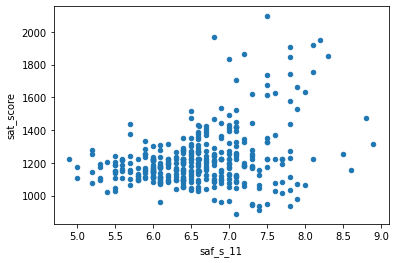

In [31]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

There appears to be a correlation between SAT scores and safety, although it isn't very strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score low than `6.5` has an average SAT score higher than `1500` or so. 

Let's explore this relationship, by aggregating by district, which will enable us to understand how safety varies district-by-district.

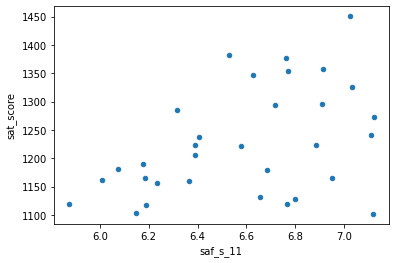

In [32]:
by_district = combined.groupby('school_dist').agg(np.mean).reset_index()
by_district.plot.scatter('saf_s_11', 'sat_score')
plt.show()

The relationship is also visible on the district level. There is a higher spread of SAT scores as the safety score increases. 
We'll further refine our aggregation and look at borough safety.

In [33]:
import folium
import branca.colormap as cm

boros = combined.groupby('boro').agg(np.mean).reset_index()

# Set a baselayer and zoom-in on NY
school_map = folium.Map(location=[40.693943, -73.9858880], 
                       zoom_start=10, 
                       tiles='CartoDB positron')
# title
map_title = "NYC High Schools: Safety Score and Enrollment by Boroughs"
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(map_title)
school_map.get_root().html.add_child(folium.Element(title_html))

# Column names for viz
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# Colormap to shade the circles on the map
start_col_val = boros[color_parameter].min()
end_col_val = boros[color_parameter].max()
start_col_hex = '#d01c8b'
end_col_hex = '#4dac26'

colormap = cm.LinearColormap(colors=[start_col_hex, end_col_hex],
                            vmin=start_col_val,
                            vmax=end_col_val)
colormap.caption = 'Safety Score'
for index, row in boros.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="Borough "+row["boro"]+
                      " <br> Safety (color): {:.1f}".format(row[color_parameter])+
                      " <br> Enrollment (size): {:.0f}".format(row[size_parameter])
                 ).add_to(school_map)
school_map.add_child(colormap)
school_map

It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

<a id="4.3"></a>
## Racial Differences
There are a few columns that indicate the percentage of each race in a given school: `white_per`, `asian_per`, `black_per` and `hispanic_per`. By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

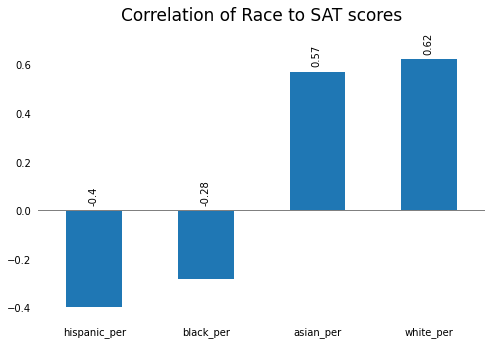

In [34]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
fig, ax = plt.subplots(figsize=(8,6))
ax = combined.corr()['sat_score'][race_fields].sort_values().plot.bar(rot = 0, 
                                                                      width = 0.5, 
                                                                      figsize = (8, 5))
ax.axhline(y = 0.0, 
           color = 'grey', 
           linestyle = '-', 
           linewidth = 1)

for key,spine in ax.spines.items():
       spine.set_visible(False)
        
for i in ax.patches:
    ax.annotate(str(round(i.get_height(), 2)),
               (i.get_x() + 0.2, max(i.get_height(), 0) + 0.03),
                rotation = 90
               )
        
ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = True) 
ax.set_title('Correlation of Race to SAT scores\n', size = 17)
plt.show()

It looks like a higher percentage of white or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of black or Hispanic students correlates negatively with SAT score. This may be due to lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or Hispanic students.

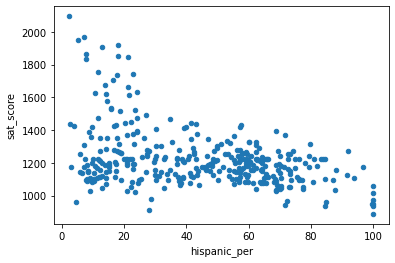

In [35]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.show()

In [36]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores. 

In [37]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn't explain the low `hispanic_per`, but it does explain why their students tend to do better on the SAT - they are students from all over New York City who did well on a standardized test. 

Let's look at the racial makeup of all the elite schools(avg.`sat_score` > 1800), compared to all schools.

In [38]:
import plotly as py  # interactive plotting
import plotly.graph_objs as go
import cufflinks as cf  # interactive plotting made easy (pandas style)

# Using plotly + cufflinks in offline mode
from plotly.offline import iplot, init_notebook_mode
cf.go_offline(connected=True)
init_notebook_mode(connected=True)
list_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']
top_sat = combined['sat_score'] > 1800

race_dist = pd.DataFrame(data = [combined.loc[:, list_race].sum() / combined.loc[:, list_race].sum().sum(),
                                 combined.loc[top_sat, list_race].sum() / combined.loc[top_sat, list_race].sum().sum()],
                         index = ['All schools', 'Elite schools']) * 100
race_dist.columns = ['Asian', 'Black', 'Hispanic', 'White']
race_dist.astype(int).iplot(kind = 'bar', barmode = 'stack', yTitle = 'Students Share %',
                            title = 'Racial Makeup | NYC High Schools <br>SAT Score > 1,800'
                            )

When it comes to the elite schools, Asian and white students are clearly overrepresented, whereas black and Hispanic students are underrepresented.

<a id="4.4"></a>
## Gender Differences

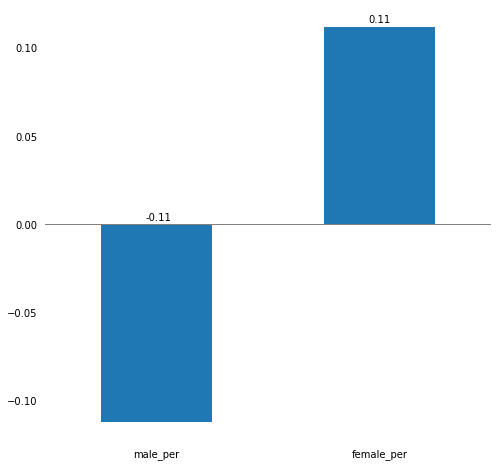

In [39]:
gender = ["male_per", "female_per"]

ax = combined.corr()['sat_score'][['male_per','female_per']].plot(kind="bar",
                                                                  rot=0,
                                                                  figsize=(8, 8))
for key,spine in ax.spines.items():
       spine.set_visible(False)
for p in ax.patches: # set data point labels
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + 0.2, max(p.get_height(), 0)+0.002),
                rotation=0
                )
ax.tick_params(bottom = False, top = False, left = False, right = False, labelbottom = True) 
ax.axhline(y=0.0, color='grey', linestyle='-', linewidth=1)
plt.show()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is extremely strong. 

In [40]:
import warnings
with warnings.catch_warnings(): # to catch FutureWarning about np.module being used in pandas
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='female_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["female_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='Share females, %',
        yTitle='Avg. SAT score',
        title='Share of female students vs. SAT score by school <br> dashed lines: average of entire dataset'
    )

Based on the scatter plot, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females(`60` to `80`) and high SAT scores. 
Majority of these schools are in `Manhattan` and `Queens` boroughs.

In [41]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)][["SCHOOL NAME", "boro"]]

,SCHOOL NAME,boro
5,BARD HIGH SCHOOL EARLY COLLEGE,Manhattan
26,ELEANOR ROOSEVELT HIGH SCHOOL,Manhattan
60,BEACON HIGH SCHOOL,Manhattan
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,Manhattan
302,TOWNSEND HARRIS HIGH SCHOOL,Queens


These schools appear to be very selective liberal arts schools that have high academic standards. 

<a id="4.5"></a>
## Advanced Placement(AP) Scores
In the U.S., high school students take AP exams to earn college credit. There are AP exams for many different subjects. It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. 

Because `total_enrollment` is highly correlated with `sat_score`, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [42]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]*100

In [43]:
with warnings.catch_warnings(): # to catch FutureWarning about np.module being used in pandas
    warnings.filterwarnings("ignore",category=FutureWarning)
    combined.iplot(
        x='ap_per',
        y='sat_score',
        categories='boro',
        text="SCHOOL NAME",
        vline= {"x":combined["ap_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
        hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
        xTitle='AP-Test Takers, %',
        yTitle='Avg. SAT score',
        title='Share of AP-Test takers vs. SAT score by school <br> dashed lines: average of entire dataset'
    )


It looks like there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. However, it is not a very strong correlation. 

<a id="5"></a>
# Conclusions
* Black and Hispanic students do worse than their White and Asian counterparts. They attend schools in less secure areas and are less frequently accepted into the prestigious high schools in their boroughs.
* Male students make up a large share of the students in top STEM-focused schools whereas female students tend to predominately attend prestigious high schools in liberal arts.
* Advanced Placement exams scores do not provide the best benchmark for SAT results.